# AGDC-V2 API Functional Testing


##  Setting up environment: python modules etc

* Optional! 
* Skip this section if you use other means to ensure correct env setup, 
* such as module load before starting jupyter notebook.

In [2]:
from IPython.display import display
from pprint import pprint
from __future__ import print_function

from collections import defaultdict
import xarray as xr
import xarray.ufuncs

import datacube
from datacube.api import GridWorkflow, masking
#from datacube.index import index_connect
#from datacube.config import LocalConfig
#from datacube.api._conversion import to_datetime
#new updated version: from datacube.api import make_mask, describe_flags

import numpy as np
import math

#from pyproj import Proj, transform
from osgeo import gdal, osr, ogr
from rasterio.warp import reproject, RESAMPLING
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels


Python envionment and modules are ready to go

## API with your specific configuration

In [3]:
dc = datacube.Datacube(config='/home/547/adh547/unification.datacube.conf', app='wofs-dev')

In [4]:
gw = GridWorkflow(dc, product='ls5_nbar_albers')

## List_cells ()
The is now no need to call list_cells for tile-based workflows, unless you just want to list the area covered:

In [5]:
cells = gw.list_cells(product_type='nbar', 
                      longitude=(149.06,149.18), latitude=(-35.27, -35.33), 
                      time=('1996-01-01', '2016-03-20'))
cells

{(14, -42),
 (14, -41),
 (14, -40),
 (14, -39),
 (15, -42),
 (15, -41),
 (15, -40),
 (15, -39),
 (15, -38),
 (16, -42),
 (16, -41),
 (16, -40),
 (16, -39),
 (16, -38),
 (17, -41),
 (17, -40),
 (17, -39),
 (17, -38)}

## List Tiles

In [6]:
nbar_tiles = gw.list_tiles(product_type='nbar', platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'],
                           longitude=(149.06,149.18), latitude=(-35.27, -35.33), 
                           time=('1996-01-01', '2016-03-20'))
sorted(nbar_tiles.keys())

[(14, -42),
 (14, -41),
 (14, -40),
 (14, -39),
 (15, -42),
 (15, -41),
 (15, -40),
 (15, -39),
 (15, -38),
 (16, -42),
 (16, -41),
 (16, -40),
 (16, -39),
 (16, -38),
 (17, -41),
 (17, -40),
 (17, -39),
 (17, -38)]

When using the search terms, there is not currently a way to filter out non-tile based data, such as scenes, which go far beyond the requested area. For now we must use **`product='ls5_nbar_albers'`**.

In [7]:
nbar_tiles = gw.list_tiles(product='ls5_nbar_albers',
                           longitude=(149.06, 149.18), latitude=(-35.27, -35.33), 
                           time=('1996-01-01', '2016-03-20'))
sorted(nbar_tiles.keys())

[(15, -40)]

In [8]:
pq_tiles = gw.list_tiles(product='ls5_pq_albers',
                         longitude=(149.06, 149.18), latitude=(-35.27, -35.33), 
                         time=('1996-01-01', '2016-03-20'))
sorted(pq_tiles.keys())

[(15, -40)]

In [9]:
# Cell, Time -> Product -> TileDef
tile_def = defaultdict(dict)

for cell, tiles in nbar_tiles.items():
    for time, tile in tiles.items():
        tile_def[cell, time]['nbar'] = tile

for cell, tiles in pq_tiles.items():
    for time, tile in tiles.items():
        tile_def[cell, time]['pqa'] = tile

for i, products in tile_def.items():
    if len(products) < 2:
        print('Only found {products} at cell: {cell} at time: {time}'.format(
                products=products.keys(), cell=cell, time=time))

In [10]:
len(tile_def)

21

Get the key for the first tile:

In [11]:
keys = list(tile_def)
key = keys[0]
key

((15, -40), numpy.datetime64('1996-06-06T23:02:40.000000000'))

In [12]:
tile_def[key]

{'nbar': <xarray.DataArray (time: 1)>
 array([ (Dataset <id=eaedc56f-4144-4423-9664-b238dde708db type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_19960606230240000000.nc>,)], dtype=object)
 Coordinates:
   * time     (time) datetime64[ns] 1996-06-06T23:02:40,
 'pqa': <xarray.DataArray (time: 1)>
 array([ (Dataset <id=bda0f296-16d8-4351-bbc6-27351a603a43 type=ls5_pq_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_PQ/LS5_TM_PQ_3577_15_-40_19960606230240000000.nc>,)], dtype=object)
 Coordinates:
   * time     (time) datetime64[ns] 1996-06-06T23:02:40}

Load the nbar data for the first tile:

In [13]:
cell = key[0]
tile = tile_def[key]['nbar']
nbar_data = gw.load(key[0], tile)

We can use the `nodata` value, or use the contiguous bit in the PQ data to mask out nulls.

Here is `nodata`:

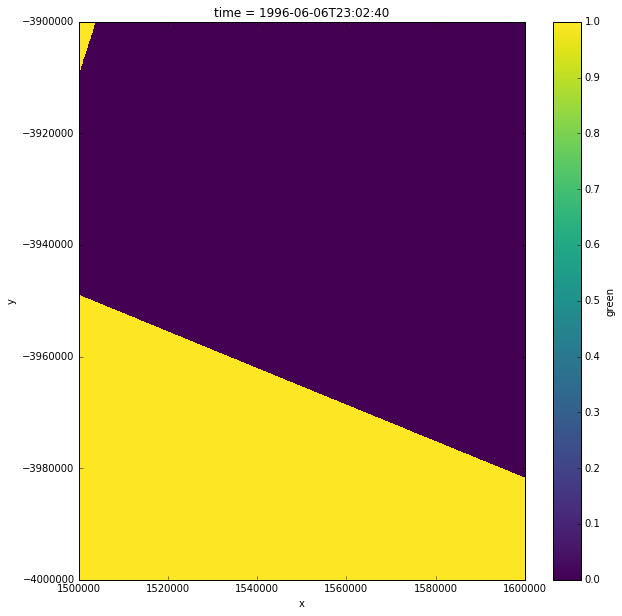

In [14]:
no_data = (nbar_data.green == nbar_data.green.nodata)
no_data.plot()

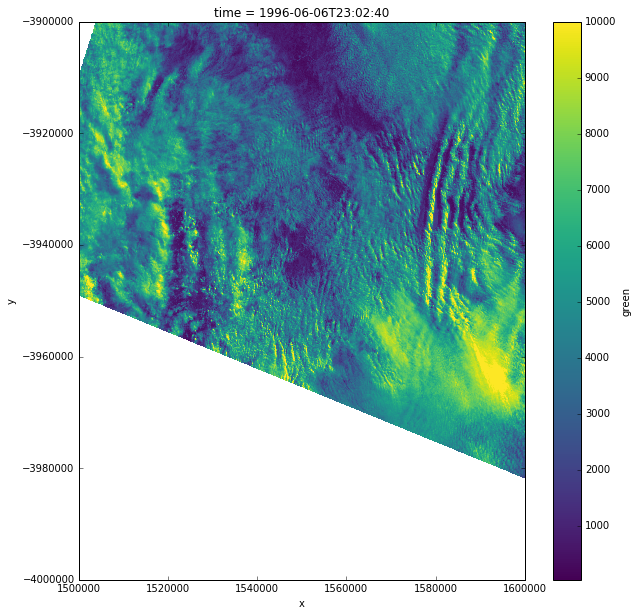

In [15]:
nbar_data.green.where(~no_data).plot()

Load the PQ data:

In [16]:
cell = key[0]
tile = tile_def[key]['pqa']
pq_data = gw.load(cell, tile)

We can look at the bits available to us:

In [17]:
import pandas
pandas.DataFrame.from_dict(masking.get_flags_def(pq_data), orient='index')

,values,bits,description
blue_saturated,"{u'1': False, u'0': True}",0,Blue band is saturated
cloud_acca,"{u'1': u'cloud', u'0': u'no_cloud'}",10,Cloud Shadow (ACCA)
cloud_fmask,"{u'1': u'cloud', u'0': u'no_cloud'}",11,Cloud (Fmask)
cloud_shadow_acca,"{u'1': u'cloud_shadow', u'0': u'no_cloud_shadow'}",12,Cloud Shadow (ACCA)
cloud_shadow_fmask,"{u'1': u'cloud_shadow', u'0': u'no_cloud_shadow'}",13,Cloud Shadow (Fmask)
contiguous,"{u'1': True, u'0': False}",8,All bands for this pixel contain non-null values
ga_good_pixel,{u'16383': True},"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",Best Quality Pixel
green_saturated,"{u'1': False, u'0': True}",1,Green band is saturated
land_sea,"{u'1': u'land', u'0': u'sea'}",9,Land or Sea
nir_saturated,"{u'1': False, u'0': True}",3,NIR band is saturated


We can make a mask from a combination of bits. Here we will use the cloud masks and the contiguous bit.

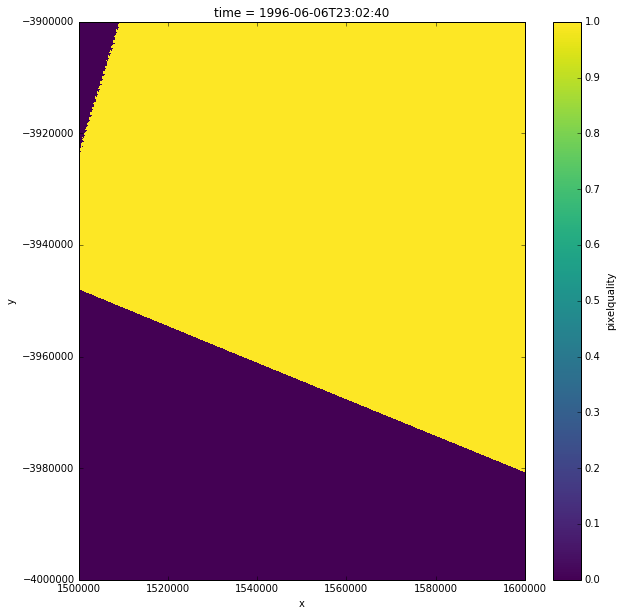

In [18]:
contiguous = masking.make_mask(pq_data, contiguous=1).pixelquality
contiguous.plot()

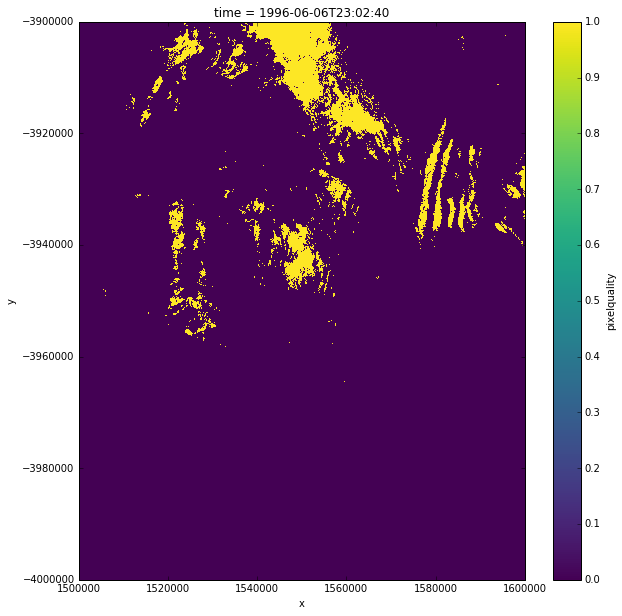

In [19]:
good_data = masking.make_mask(pq_data, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
good_data.plot()

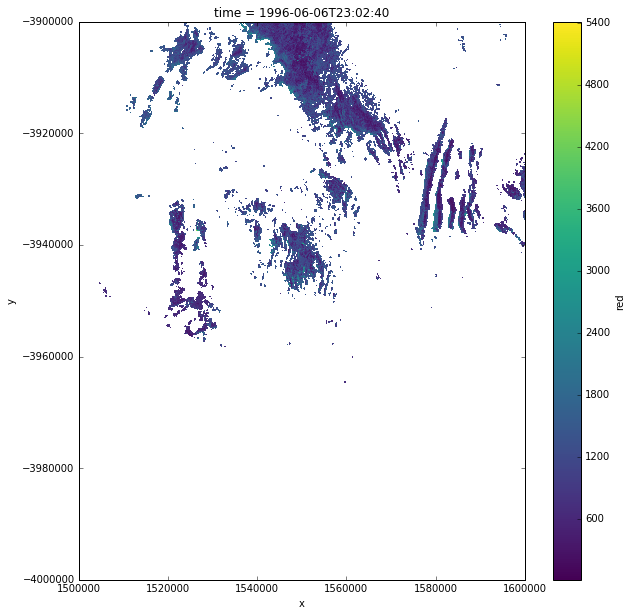

In [20]:
cloud_free_nbar = nbar_data.where(good_data)
cloud_free_nbar.red.plot()